# Getting Started with xRHEED

This notebook shows how to use xRHEED to load, inspect, and plot an RHEED example image.

In [1]:
import xrheed
from xrheed.io import load_data

import matplotlib.pyplot as plt
from pathlib import Path

## Load a RHEED data file
The RHEED images are loaded by provided plugins. A plugin should specify the geometry and poperies of the particular RHEED setup. For example:

- the screen scaling (from px to mm),
- the screen-to-sample distance,
- electron beam energy,
- the center of the screen, defined as the point in the middle of a line that connects the transmitted beam and the mirror-reflected spot

In [2]:
image_path = Path("example_data/Si_111_7x7_112_phi_00.raw")

rheed_image = load_data(image_path, plugin="dsnp_arpes_raw")
rheed_image

<xarray.DataArray (y: 1038, x: 1388)> Size: 1MB
array([[0, 0, 0, ..., 2, 1, 1],
       [0, 0, 0, ..., 1, 2, 2],
       [0, 0, 0, ..., 1, 2, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 2, 1],
       [0, 0, 0, ..., 2, 2, 2]], dtype=uint8)
Coordinates:
  * y        (y) float64 8kB -93.02 -92.92 -92.81 -92.71 ... 14.79 14.9 15.0
  * x        (x) float64 11kB -76.0 -75.9 -75.79 -75.69 ... 68.27 68.38 68.48
Attributes:
    plugin:                  UMCS DSNP ARPES Raw
    screen_sample_distance:  309.2
    screen_scale:            9.6
    screen_center_x:         76.0
    screen_center_y:         15.0
    beam_energy:             18600.0

The data are loaded into an xarray object, so the buildin methods of this library are available, as shown bellow.

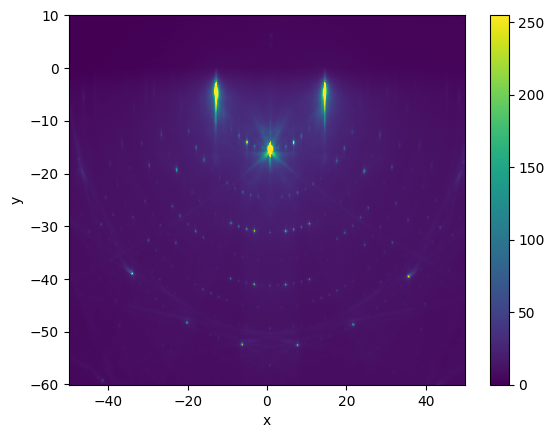

In [3]:
rheed_image.sel(x=slice(-50, 50), y=slice(-60, 10)).plot()
plt.show()

## The .R accessor
Tools dedicated to RHEED analysis are available via the .R accessory.

For example, you can access basic properties as shown below.

In [4]:
print(rheed_image.R.theta)
print(rheed_image.R.beam_energy)

1.0
18600.0


## Set the center of an image
Although the plugin used to load the data should provide the information about the screen center, we are interested more in accurate definition of so called:
- horizontal center that is defined by the line connecting the specular and transited spot,
- vertical center that is defined at the shadow boundary.
Both values depend on the particular RHEED image setup and usually needs to be fine adjusted for each image or image series.

### Manual center
The center of an image could be adjusted manually using:
`apply_screen_center()` method as shown bellow.

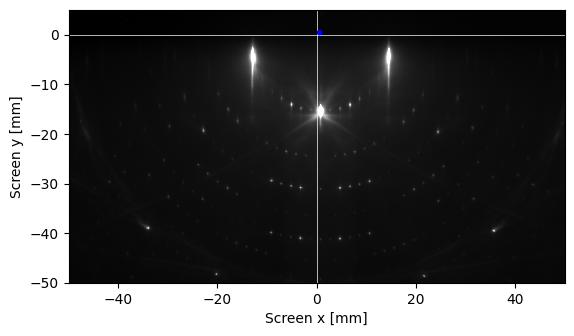

In [5]:
center_x = 0.5  #mm
center_y = 0.5 #mm

fig, ax = plt.subplots()
rheed_image.R.plot_image(ax=ax)
ax.plot(center_x, center_y, 'b.')

<Axes: xlabel='Screen x [mm]', ylabel='Screen y [mm]'>

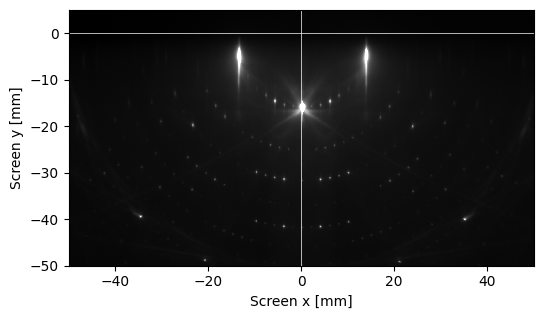

In [6]:
rheed_image.R.apply_image_center(center_x=center_x,
                                  center_y=center_y)

rheed_image.R.plot_image()

### Automated center search
There are two functions in `xrheed.preparation.alignment` that might be used to find vertical and horizontal center.

It is recommended to first find the horizontal center using `find_horizontal_center(image)`, apply the correction and then use `find_vertical_center(image)`. 

Alternatively those functions could be called automatically using, mentioned above accessory `apply_image_center(automatic=True)`.

Please note that automatic center search may not work for asymmetric images.



0.375
-0.8941663158864128


<Axes: xlabel='Screen x [mm]', ylabel='Screen y [mm]'>

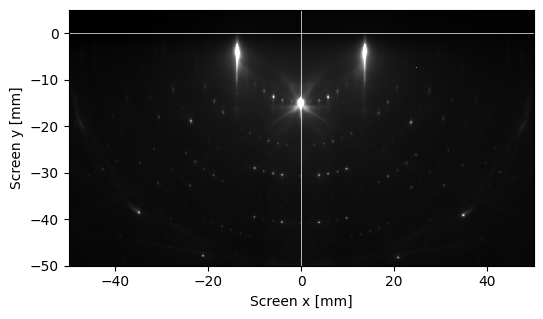

In [7]:
from xrheed.preparation.alignment import find_vertical_center, find_horizontal_center

# try to find center in horizontal
center_x = find_horizontal_center(rheed_image)
center_y = find_vertical_center(rheed_image, shadow_edge_width=5.0)

print(center_x)
print(center_y)

# or use automatic center search
rheed_image.R.apply_image_center(auto_center=True)
rheed_image.R.plot_image()


## Image rotation

In [8]:
rheed_image.R.rotate(angle=-0.5)
rheed_image.R.apply_image_center(auto_center=True)

## Screen ROI 
Setup the screen region of interest (ROI) that is used to plot the image

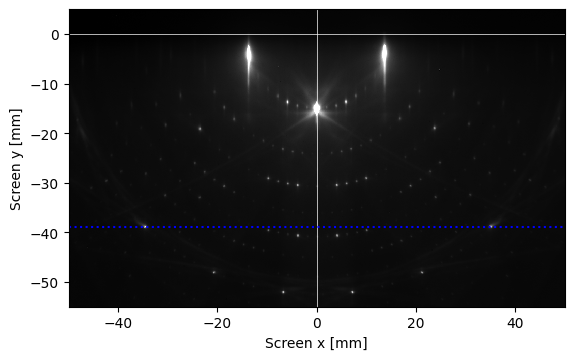

In [9]:
rheed_image.R.screen_roi_width = 50
rheed_image.R.screen_roi_height = 55

fig, ax = plt.subplots()
rheed_image.R.plot_image(ax=ax)

# add horizontal line to check the rotation alignement
ax.axhline(-39.0, color='b', linestyle=':')

plt.show()

## High pass filter 

Use high pass filter to remove homogenous background signal.

Adjust hp_sigma, and hp_threshold values. Use `plot_image(hp_filter=True)` to plot filtered image - the original data are still onchange, the high pass filter is applied only during a plot.



<Axes: xlabel='Screen x [mm]', ylabel='Screen y [mm]'>

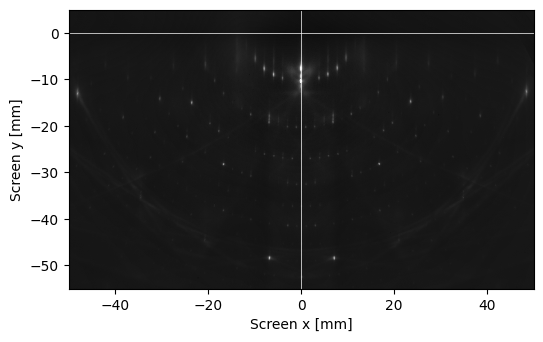

In [10]:
rheed_image.R.hp_sigma = 50.0
rheed_image.R.hp_threshold = 0.9

rheed_image.R.plot_image(hp_filter=True)